# CS-i MNIST Classifier v1

## Intro
* **Date**: 11/28/2020 - 12:08 AM :)
* **What**: This is my first crack at an actual classifier using CS-i (CompSpec Infilteration) neurons.  Basically we have the input layer, one hidden layer, and then the classification layer.  The input and hidden layers are both made of mini-batched cs-i neurons.  The most unnatural aspect of this network is that I'm causing the classification neurons to automatically win on their correct classification.  I'd like for these to be a bit more natural, but this is effectively enforcing "correct" behavior for the time being.  By more natural, I mean it be great if each classification neuron had a pre-synaptic neuron with a large weight that takes the value of 1 if the input is its given classification, and is zero otherwise.  But whatever.  Let's see if this one works first.
* **Why**: This section is entirely unnecessary.  Why do I want to build a CS-i classifier?  Because I want to burn backprop to the ground.  Stuff it.
* **Hopes**: As I just mentioned, in a perfect world, this classifier would get a super high classification way more efficiently than a network trained with backprop.  This isn't a perfect world, however, so I'll take what I can get.  
* **Limitations**: Oh gosh, I don't even know where to begin.  The prototypes aren't good enough, the network is "over-fitting" on certain inputs, it doesn't properly take into account outliers.  I don't know.  A lot of shit could go wrong.  Let's just see what goes wrong, OK?

## Code

In [64]:
import numpy as np
import matplotlib.pyplot as plt

from time import time
from tensorflow.keras.datasets import mnist
from tqdm import tqdm

L = 28 * 28   #Size of mnist in pixels
S = 60000     #Size of training set

(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X / 255.0

flat_x = np.reshape(train_X, [-1, L])
flat_test = np.reshape(test_X, [-1, L])

In [65]:
def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()   

In [123]:
"""
flat_x: training data
train_y: training classifications
S: Size of training set
L: Size of input
Kx: Num cols of neurons
Ky: Num rows of neurons
Nep: Num epochs
T_s: Number of training inputs
xi: Base learning constant
phi: Specialization ema constant
B: Batch size
prec: The smallest value allowed for the norm of the filtered weight vector

Returns: (synapse_weights, neuron specialization values)
"""
def classifier(flat_x, train_y, S, L, Kx, Ky, Nep, T_s, xi, phi, B, prec):
    start = time()
    N = Kx * Ky
    
    w = np.abs(np.random.normal(0, 1, (N, L))) # synapses of each neuron
    w = w / np.array([np.linalg.norm(w, axis=1)]).T #NORMALIZE THE WEIGHTS TO PREVENT EXXXPLOSIONS
    s = np.zeros(N).reshape(-1, 1) # Specialization for each neuron+
    
    w_c = np.abs(np.random.normal(0, 1, (10, N))) # synapses of each neuron
    w_c = w_c / np.array([np.linalg.norm(w_c, axis=1)]).T #NORMALIZE THE WEIGHTS TO PREVENT EXXXPLOSIONS
    s_c = np.zeros(10).reshape(-1, 1) # Specialization for each neuron+
    
    inputs = flat_x
    in_sq = np.square(inputs)
    in_norm = np.linalg.norm(inputs, axis=1)
    
    win_c_mask = np.zeros((10, train_y.shape[0]))
    win_c_mask[train_y, np.arange(train_y.shape[0])] = 1
    
    for ep in range(Nep):
        for i in tqdm(range(T_s // B)):
            # Handle hidden layer
            v = inputs[i * B: (i + 1) * B]
            v_sq = in_sq[i * B: (i + 1) * B].T #Automatically transpose
            v_norm = in_norm[i * B: (i + 1) * B]
        
            wv_v = w @ v_sq
            
            wv_wv_norm = np.sqrt(np.maximum(np.square(w) @ v_sq, prec))
        
            o = wv_v / (wv_wv_norm * v_norm)
        
            w_mul_v = w @ v.T 
            
            c = (1 - s) / (1 - o)

            wins = np.argmax(c, axis=0)     

            win_mask = np.zeros((N, B))
            win_mask[wins, np.arange(B)] = 1
            win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

            win_avg = (np.sum(w_mul_v * win_mask, axis=1)).reshape(-1, 1)

            v_update = win_mask @ v

            w += (v_update - (win_avg * w)) * (((1 - s) ** 2) + 0.1) * xi

            s[wins] *= (1 - phi)
            s += phi * np.sum(o * win_mask, axis=1).reshape(-1, 1)
            
            #Handle classification layer
            batch_win_c_mask = win_c_mask[:, i * B: (i + 1) * B]
            batch_win_c_mask = batch_win_c_mask / np.maximum(np.sum(batch_win_c_mask, axis=1), 1).reshape(-1, 1)
            
            batch_wins = train_y[i * B: (i + 1) * B]
            
            v_sq_c = np.square(o)
            v_norm_c = np.linalg.norm(o, axis=0)
            
            wv_v_c = w_c @ v_sq_c
            
            wv_norm_c = np.sqrt(np.maximum(np.square(w_c) @ v_sq_c, prec))
            
            o_c = wv_v_c / (wv_norm_c * v_norm_c)
            
            w_mul_v_c = w_c @ o
                    
            win_avg_c = (np.sum(w_mul_v_c * batch_win_c_mask, axis=1)).reshape(-1, 1)
            
            v_update_c = batch_win_c_mask @ o.T
            
            w_c += (v_update_c - (win_avg_c * w_c)) * (((1 - s_c) ** 2) + 0.1) * xi
            
            s_c[batch_wins] *= (1 - phi)
            s_c += phi * np.sum(o_c * batch_win_c_mask, axis=1).reshape(-1, 1)
            
#         draw_weights(w, Kx, Ky)

    print("Max val: ", np.amax(s), "Min value: ", np.amin(s), "Mean val: ", np.mean(s), "Std: ", np.std(s))
    print("Elapsed time: ", time() - start, " seconds")
    
    return (w, s, w_c, s_c)

In [72]:
def classify(w, w_c, v):
    v_sq = np.square(v).T #Automatically transpose
    v_norm = np.linalg.norm(v)

    wv_v = w @ v_sq

    wv_wv_norm = np.sqrt(np.maximum(np.square(w) @ v_sq, prec))

    o = wv_v / (wv_wv_norm * v_norm)

    #Handle classification layer
    v_sq_c = np.square(o).T
    v_norm_c = np.linalg.norm(o)

    wv_v_c = w_c @ v_sq_c

    wv_norm_c = np.sqrt(np.maximum(np.square(w_c) @ v_sq_c, prec))

    o_c = wv_v_c / (wv_norm_c * v_norm_c)
    
#     print(o_c)
    
    return np.argmax(o_c)

In [121]:
def get_accuracy(w, w_c, flat_test, test_y):
    num_correct = 0
    
    mis_c = np.zeros(10)
    for (v, lbl) in tqdm(zip(flat_test, test_y)):
        if classify(w, w_c, v) == lbl:
            num_correct += 1 
        else:
            mis_c[lbl] += 1
            
    print("Misclassified inputs:", mis_c)
    print("Model accuracy:", 100 * num_correct / flat_test.shape[0])
            
    return 100 * num_correct / flat_test.shape[0]

In [124]:
def plot_everything(w, w_c, x, y):
    plt.figure(figsize=(2 * 2 * x, 2 * y))

    w_c_t = w_c.T

    for i in range(x * y):
        plt.subplot(y, 2 * x, (2 * i) + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(w[i].reshape(28, 28), cmap='Greys')
        plt.subplot(y, 2 * x, (2 * i) + 2)
        plt.xticks(range(10))
        plt.yticks([])
        plt.bar(range(10), w_c_t[i], color='blue')

    plt.show()

## Analysis Dialog

Well fam, this classifier fucking sucks. Fantastic.  Let me show you this bad boi in action.  

100%|██████████| 300/300 [00:00<00:00, 337.22it/s]


Max val:  0.9900142013263319 Min value:  0.9111891866705012 Mean val:  0.9706554536146745 Std:  0.01358383586854045
Elapsed time:  3.3600149154663086  seconds





10000it [00:02, 3415.22it/s]


[ 14. 446. 819. 578. 644. 803. 333. 403. 951. 600.]
Classifier Accuracy: 44.09


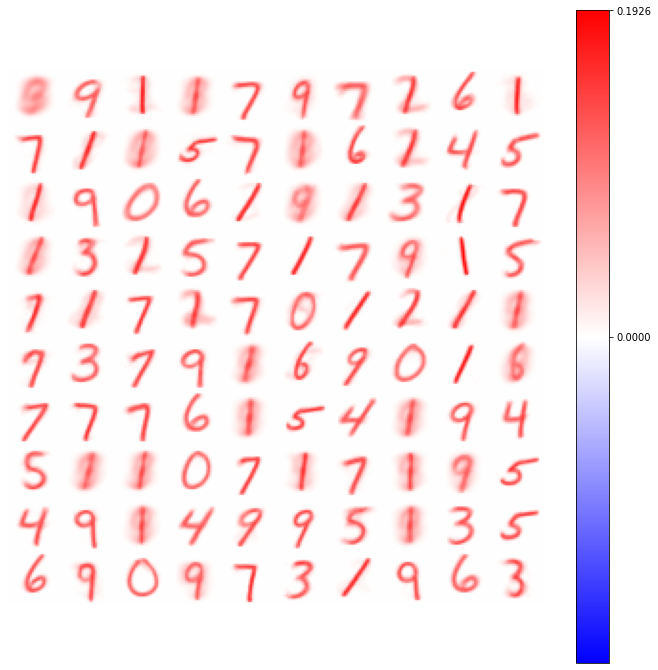

In [88]:
%matplotlib inline
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 10
Ky = 10
Nep = 3
T_s = 60000
xi = 0.1
theta = 2 / 17
phi = 2 / 11

B = 200 #Batch size

prec = 0.01

(w, s, w_c, s_c) = classifier(flat_x, train_y, S, L, Kx, Ky, Nep, T_s, xi, phi, B, prec)
print("\n\n")
draw_weights(w, Kx, Ky)
print("Classifier Accuracy:", get_accuracy(w, w_c, flat_test, test_y))

Yup.  45% accuracy.  Doesn't exactly blow backprop out of the water, as was desired.  I'm going to see if I can plot the weight-prototype and classification prototype side by side.

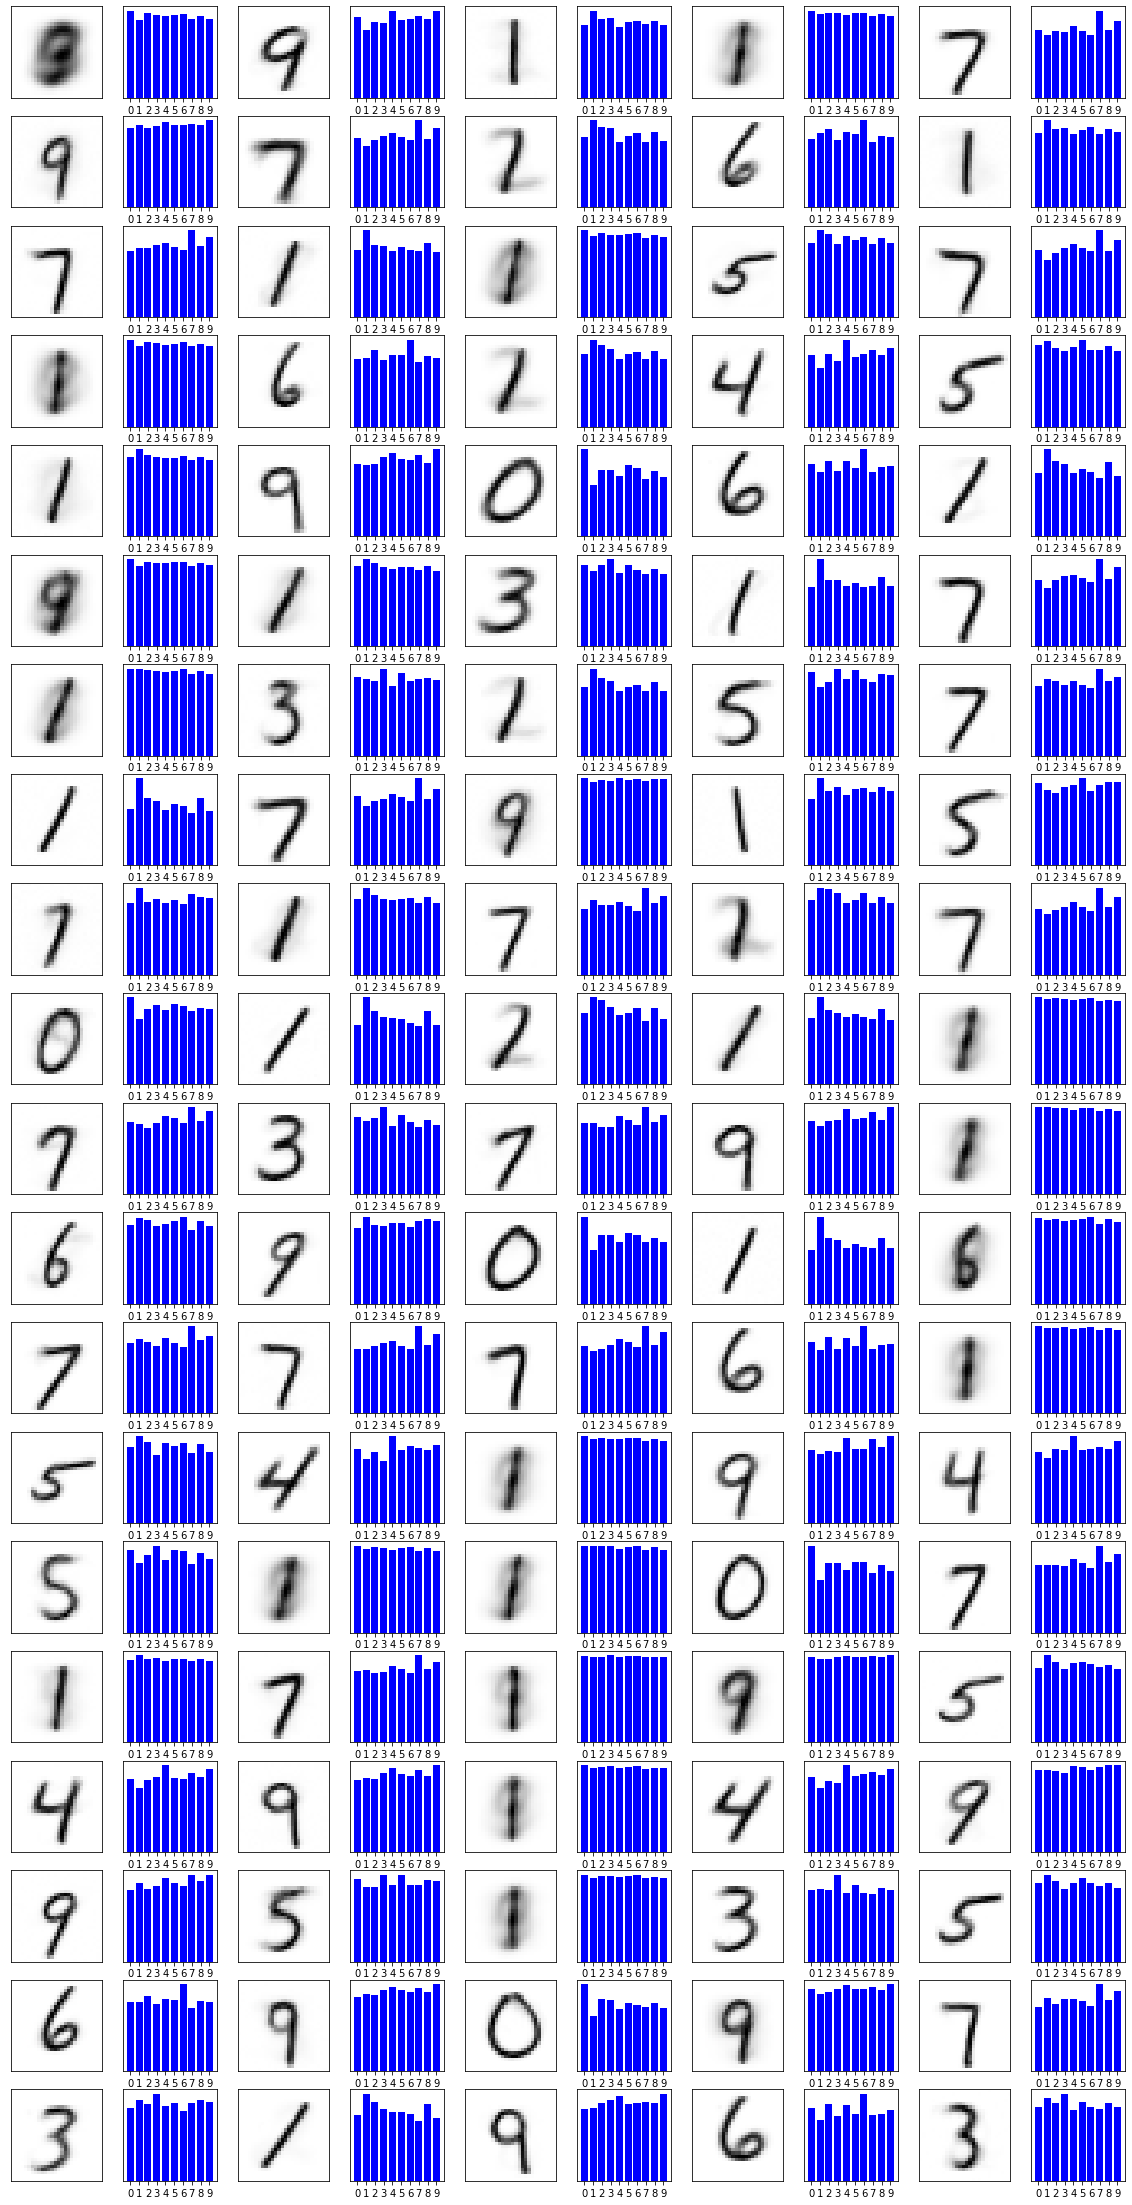

In [120]:
plot_everything(w, w_c, 5, 20)

Ok, this really shows what is super not great about about CS-i.  I think because we're normalizing the output, the output vectors are just kinda unreasonably high for everything.  

So yeah, I think CS-i is kinda a bust.  Luckily, I had an emotional crisis coming down from my three day, CompSpec induced high, and I think I came up with a better way to do filtered output.  Spoiler alert: spherical learning is going out the fucking window.  

While this experiment basically just makes me sad, I'm going to do a couple more classifications with different numbers of neurons.  We'll just have to see what happens.  

100%|██████████| 300/300 [00:00<00:00, 691.12it/s]


Max val:  0.9788385226064856 Min value:  0.9424373689942523 Mean val:  0.9686125821158491 Std:  0.013214721272338614
Elapsed time:  1.7236855030059814  seconds





10000it [00:00, 24102.76it/s]


Misclassified inputs: [   2. 1006. 1029. 1002.  982.  892.  602.  658.  974. 1008.]
Model accuracy: 18.45


<Figure size 864x864 with 0 Axes>

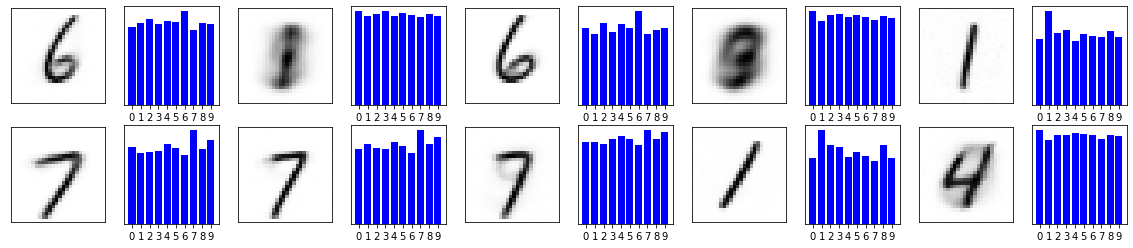

In [125]:
%matplotlib inline
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 2
Ky = 5
Nep = 3
T_s = 60000
xi = 0.1
theta = 2 / 17
phi = 2 / 11

B = 200 #Batch size

prec = 0.01

(w, s, w_c, s_c) = classifier(flat_x, train_y, S, L, Kx, Ky, Nep, T_s, xi, phi, B, prec)
print("\n\n")
get_accuracy(w, w_c, flat_test, test_y)
plot_everything(w, w_c, 5, 2)

Wow.  That's brutal.  The inputs are activating so much.  Alright, I'm going to do 400 neurons, and then we're calling this one quits.

100%|██████████| 300/300 [00:04<00:00, 69.25it/s]


Max val:  0.989955376026479 Min value:  0.919549581677609 Mean val:  0.9683951373624666 Std:  0.011055797911163399
Elapsed time:  13.243912696838379  seconds





10000it [00:16, 599.50it/s]


Misclassified inputs: [ 34. 390. 578. 509. 572. 710. 250. 376. 859. 500.]
Model accuracy: 52.22


<Figure size 864x864 with 0 Axes>

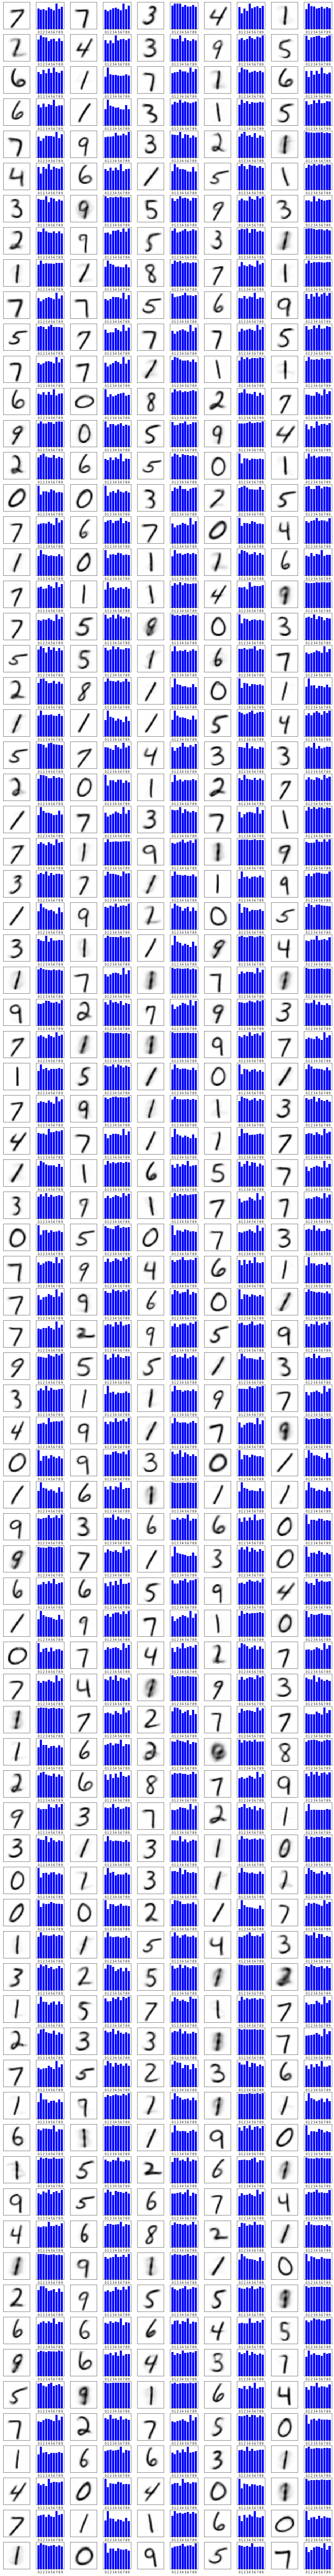

In [126]:
%matplotlib inline
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 20
Ky = 20
Nep = 3
T_s = 60000
xi = 0.1
theta = 2 / 17
phi = 2 / 11

B = 200 #Batch size

prec = 0.01

(w, s, w_c, s_c) = classifier(flat_x, train_y, S, L, Kx, Ky, Nep, T_s, xi, phi, B, prec)
print("\n\n")
get_accuracy(w, w_c, flat_test, test_y)
plot_everything(w, w_c, 5, 80)

Gosh, it's really gross how much everything is being activated.  It's interesting because there are certainly numbers that are getting the right type of classification.  Check out the 0 directly overhead.  The algo definitely knows that one's a zero.  But anything fuzzy?  Right into the garbage.  Check out the fuzzy 1 three up from the far right.  It's literally activating everything.  Gross!  Yeah I need an algo that doesn't normalize to the filtered input vector.  Luckily I got a good idea about how to try to fix this.  CS-i2 baby.  Let's go to conclusions.

## Conclusions

Well, after having everything work out in a big way for the last couple experiments before this one, this was kinda an emotional letdown.  But I suppose I got high and then I crashed.  That's the way I be. 

Anyway, enough about me, let's talk about what's going wrong.  Actually, hey, let's talk about what is going right.  46-52% accuracy isn't dogshit.  I mean it kinda is, but it's not a terrible place to start.  And as I alluded to in the previous previous paragraph, this network is many times learning the proper classification of the prototypes.  Great.  

Now.  What's going wrong?  The fucking $\left<wq, wq\right>$ term in the denominator of the output function, that's what.  Due to that normalizing factor, weight prototypes that are very weak in the neighborhood of the input vector are still being activated in a big way.  That's not good.  So yeah, I just need to think up a way for the neurons to show more specialization in what they're strongly (and medially) activated by.

## Next steps

After thinking about the limitations of CompSpec and CS-i for the past couple days, there are a couple things that I absolutely need to try.  First and foremost, I need to build a new filtering mechanism.  As I mentioned in the conclusion section and elsewhere, my current neuron output calculation is being too generous in the inputs that are getting a strong activation.  As I mentioned, we got CS-i2 coming up.  

I'm also getting increasingly perturbed by the presence of fuzzy threes.  They indicate that they're sucking up a bunch of outlier input vectors, which means CompSpec prototypes may be overly dependent on the state of the initial data.  I'm thinking I need to re-introduce the win-rate term back into the competition value to be sure that all the neurons are winning with approximately equal frequency.  The last time I tried that was in the OG CompSpec experiment, and I noticed that I wasn't getting great digit representation.  Maybe if I try to learn filters instead of prototypes I'll get a better result.  

Another way to go about this is to change how specialization is represented in the competition term.  Specialization's main purpose is to be sure that all the neurons move quickly from noise to a legitimate representation.  In KH's network, but just wta, the network learned a bunch of diverse prototypes, so what if I set things up so that past a certain threshold of specialization, the network basically behaves like wta.  I kinda like that idea.  I'm thinking an exponential term summed with a constant.  Yeah.  That seems great.

I also want to see how the network does with sequential data.  I want to be optimistic, but I feel like it's not going to go well.  By sequential data, I mean ordered data (so all the ones then all the twos, and so forth).  

So yeah I got a bunch of variants on CompSpec that I want to try, so I think it's high time for a cookhouse, baby.